# Imports

In [1]:
# Para melhor organização dos dados em tabelas/matrizes
import pandas as pd

# Para separação de dados de treino e teste de forma consistente
from sklearn.model_selection import train_test_split

# Para tratamento dos dados
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Para otimizar hiperparâmetros
import optuna
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

# Para fazer árvore de decisão
from sklearn.tree import DecisionTreeClassifier
# Para fazer random forest
from sklearn.ensemble import RandomForestClassifier
# Para fazer naive bayes
from sklearn.naive_bayes import GaussianNB

# Matriz de confusão para comparação ed resultado
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report

c:\Linguagens\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dados

## Import da base padrão

In [2]:
# Leitura e foramtação dos dados
dados = pd.read_csv('Data/titanic.csv', sep=';', na_values=["", " ", "NA", "N/A"])
dados = dados['PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked'].str.split(',', expand=True)
dados.columns = ['PassengerId', 'Survived', 'Pclass', 'Surname', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
dados = pd.DataFrame(dados)

## Atributos descartados

In [3]:
# PassengerId é condizente com a própria numeração na tabela (index) e único a cada um
dados = dados.drop(columns=['PassengerId'])
# Nome é um atributo sempre único e sem impacto na sobrevivência do passageiro
dados = dados.drop(columns=['Surname', 'Name'])
# Ticket é provavelmente irrelevante (supondo que não reflete fatores como localização no navio e outros)
dados = dados.drop(columns=['Ticket'])
# Cabine pode ser relevante, mas tem uma taxa de 77% dos dados nulos, sendo então impreciso para a análise
dados = dados.drop(columns=['Cabin'])
# O local de embarque não deve impactar a sobrevivência do passageiro, além de que uma maioria absoluta (72%) vieram do mesmo porto
dados = dados.drop(columns=['Embarked'])

## Conversão de valores binários

In [4]:
cols_label_encode = ['Sex']
dados[cols_label_encode] = dados[cols_label_encode].apply(LabelEncoder().fit_transform)

## Tratamento de dados vazios

In [5]:
# Obter moda e inserir no lugar
for column in dados.columns:
    grupo = dados[column]

    # Determinar moda
    moda = Counter(grupo).most_common(1)[0][0]
    if not moda:
        moda = Counter(grupo).most_common(2)[1][0]
    #print("Moda de ", column, "é ", moda)

    # Preencher dados vazios
    dados[column] = dados[column].fillna(moda)
    for linha in range(len(dados)):
        if ( type(dados[column][linha]) == str ):
            if not ( len(dados[column][linha]) > 0 ):
                #print ("Str: ", linha, dados[column][linha])
                dados.loc[linha, column] = ( moda )
                #print ("Str (new): ", linha, dados[column][linha])
        elif ( type(dados[column][linha]) == int ):
            if not ( dados[column][linha] >= 0 ):
                #print ("Int: ", linha, dados[column][linha])
                dados.loc[linha, column] = ( moda )
                #print ("Int (new): ", linha, dados[column][linha])

## Separação dados treino/teste

In [6]:
# Separação de dados de atributo da conclusão
dados_atributos = dados.drop(columns=['Survived'])    # Atributos
dados_resultado = dados.iloc[:, [0]]                # Conclusão

# Separar dados
treino_atributos, teste_atributos,treino_resultado, teste_resultado = train_test_split(dados_atributos, dados_resultado, test_size = 0.20, random_state = 69)

# Otimização de hiperparâmetros

## Algoritmo de otimização Bayeano (Bayesian Optimization)

In [7]:
def objetivo_otimizacao_randomforest(tentativa):
    # Definição do espaço de hiperparâmetros
    n_estimators = tentativa.suggest_int('n_estimators', 50, 250)
    max_depth = tentativa.suggest_int('max_depth', 5, 10, log=True) # log=True para valores mais próximos a 1
    max_features = tentativa.suggest_float('max_features', 0.5, 1.0)
    min_samples_leaf = tentativa.suggest_float('min_samples_leaf', 0.0, 0.2)

    # Criação do modelo
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features= max_features, min_samples_leaf= min_samples_leaf, random_state=69)
    
    # Treinamento do modelo
    model.fit(treino_atributos, treino_resultado)
     
    # Predição nos dados de teste
    prev = model.predict(teste_atributos)
     
    # Retorna a acurácia como objetivo
    return accuracy_score(teste_resultado, prev)

def objetivo_otimizacao_decisiontree(tentativa):
    # Definição do espaço de hiperparâmetros
    max_depth = tentativa.suggest_int('max_depth', 5, 10, log=True) # log=True para valores mais próximos a 1
    min_samples_leaf = tentativa.suggest_float('min_samples_leaf', 0.0, 0.2)

    # Criação do modelo
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf= min_samples_leaf, random_state=69)
    
    # Treinamento do modelo
    model.fit(treino_atributos, treino_resultado)
     
    # Predição nos dados de teste
    prev = model.predict(teste_atributos)
     
    # Retorna a acurácia como objetivo
    return accuracy_score(teste_resultado, prev)

## Otimização

In [8]:
# Número de estudos
n_estudos = 100

# Decision Tree
estudo_decisiontree = optuna.create_study(direction= 'maximize')
# Otimizar
estudo_decisiontree.optimize(objetivo_otimizacao_decisiontree, n_trials=n_estudos)

# Decision Tree
estudo_randomforest = optuna.create_study(direction= 'maximize')
# Otimizar
estudo_randomforest.optimize(objetivo_otimizacao_randomforest, n_trials=n_estudos)

[I 2025-09-26 19:14:35,605] A new study created in memory with name: no-name-4b0d98e1-35ec-4b22-b993-256bc98bd582


[I 2025-09-26 19:14:35,626] Trial 0 finished with value: 0.8324022346368715 and parameters: {'max_depth': 6, 'min_samples_leaf': 0.0037511055706564325}. Best is trial 0 with value: 0.8324022346368715.
[I 2025-09-26 19:14:35,644] Trial 1 finished with value: 0.8044692737430168 and parameters: {'max_depth': 7, 'min_samples_leaf': 0.10970777750537347}. Best is trial 0 with value: 0.8324022346368715.
[I 2025-09-26 19:14:35,660] Trial 2 finished with value: 0.8044692737430168 and parameters: {'max_depth': 6, 'min_samples_leaf': 0.09160945917469397}. Best is trial 0 with value: 0.8324022346368715.
[I 2025-09-26 19:14:35,675] Trial 3 finished with value: 0.8044692737430168 and parameters: {'max_depth': 5, 'min_samples_leaf': 0.12379183218993633}. Best is trial 0 with value: 0.8324022346368715.
[I 2025-09-26 19:14:35,695] Trial 4 finished with value: 0.8044692737430168 and parameters: {'max_depth': 9, 'min_samples_leaf': 0.14423755279630382}. Best is trial 0 with value: 0.8324022346368715.
[I 

# Algoritmos

## Árvore de Decisão (CART)

In [9]:
arvore_decisao = DecisionTreeClassifier(criterion='gini', **estudo_decisiontree.best_params)
arvore_decisao.fit(treino_atributos, treino_resultado)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,0.0037511055706564325
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Random Forest

In [10]:
random_forest = RandomForestClassifier(criterion='gini', **estudo_randomforest.best_params, random_state = 69)
random_forest.fit(treino_atributos, treino_resultado)

c:\Linguagens\Python\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,110
,criterion,'gini'
,max_depth,9
,min_samples_split,2
,min_samples_leaf,0.0008450287258177195
,min_weight_fraction_leaf,0.0
,max_features,0.6338432275813707
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Naive Bayes

In [11]:
naive_bayes = GaussianNB()
naive_bayes.fit(treino_atributos, treino_resultado)

c:\Linguagens\Python\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,priors,None
,var_smoothing,1e-09


# Resultados

## Árvore de Decisão (CART)

c:\Linguagens\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


0.8324022346368715

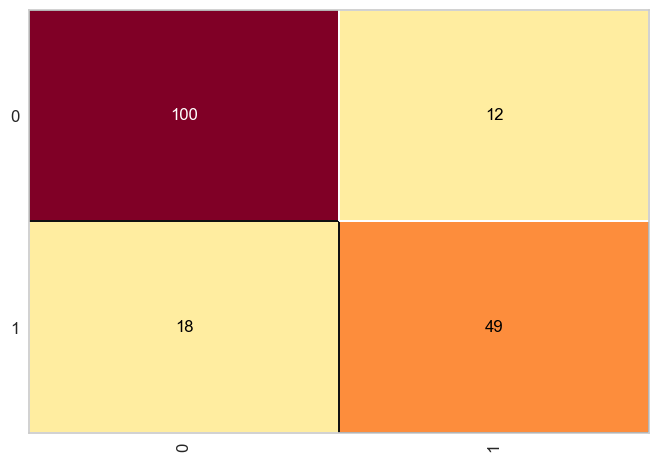

In [12]:
cm_decisiontree = ConfusionMatrix(arvore_decisao)
cm_decisiontree.fit(treino_atributos, treino_resultado)
cm_decisiontree.score(teste_atributos, teste_resultado)

In [13]:
previsoes_decisiontree = arvore_decisao.predict(teste_atributos)
print(classification_report(teste_resultado, previsoes_decisiontree))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       112
           1       0.80      0.73      0.77        67

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



## Random Forest

c:\Linguagens\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.8603351955307262

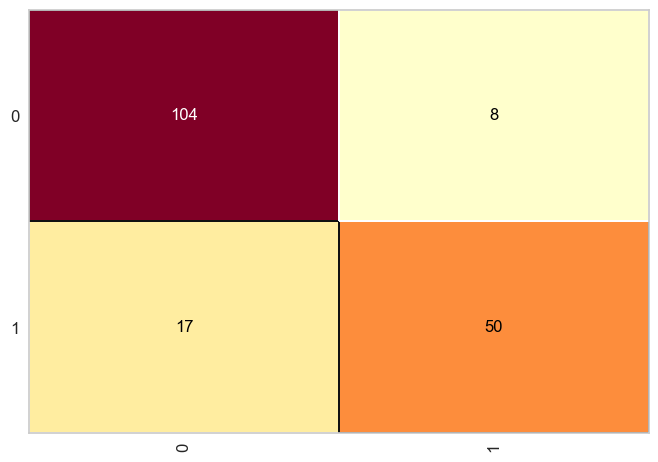

In [14]:
cm_randomforest = ConfusionMatrix(random_forest)
cm_randomforest.fit(treino_atributos, treino_resultado)
cm_randomforest.score(teste_atributos, teste_resultado)

In [15]:
previsoes_randomtree = arvore_decisao.predict(teste_atributos)
print(classification_report(teste_resultado, previsoes_randomtree))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       112
           1       0.80      0.73      0.77        67

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



## Naive Bayes

c:\Linguagens\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


0.7932960893854749

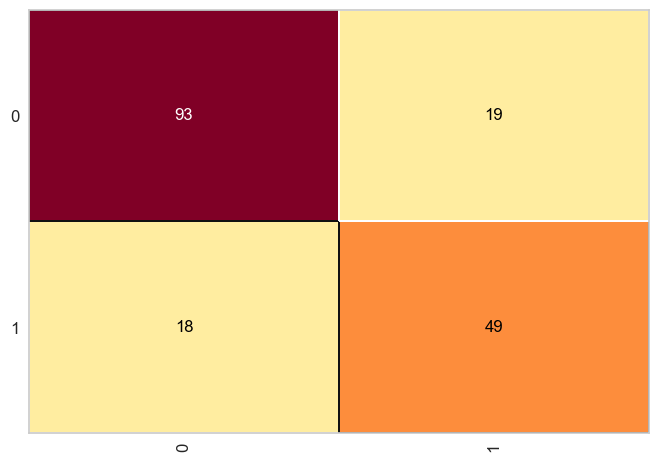

In [16]:
cm_naivebayes = ConfusionMatrix(naive_bayes)
cm_naivebayes.fit(treino_atributos, treino_resultado)
cm_naivebayes.score(teste_atributos, teste_resultado)

In [17]:
previsoes_naivebayes = arvore_decisao.predict(teste_atributos)
print(classification_report(teste_resultado, previsoes_naivebayes))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       112
           1       0.80      0.73      0.77        67

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

